# Module 3: Overview of Generative AI

## Learning Objectives
By the end of this module, you will be able to:
- Understand what makes AI "generative" vs. discriminative
- Recognize different types of generative models and their applications
- Understand latent space and representation learning
- See how probabilistic sampling creates new content

---

## 1. What is Generative AI?

### Discriminative vs Generative Models

**Discriminative Models** (what we've seen so far):
- Learn the **boundary** between classes
- Answer: "What is this?" (classification)
- Example: "This image is a cat" (probability of label given input)
- Mathematically: Model P(y|x) - probability of label given input

**Generative Models** (focus of this course):
- Learn the **data distribution** itself
- Answer: "What does this look like?" (generation)
- Example: "Generate a new image that looks like a cat"
- Mathematically: Model P(x) - probability distribution of the data

```
Discriminative:  Image → [Model] → "Cat" (classify existing data)
Generative:      "Cat" → [Model] → New Image (create new data)
```

### Applications of Generative AI

| Domain | Examples |
|--------|----------|
| **Text** | ChatGPT, Claude, writing assistants, code generation |
| **Images** | DALL-E, Midjourney, Stable Diffusion, image editing |
| **Audio** | Music generation, voice synthesis, audio editing |
| **Video** | Sora, video synthesis, deepfakes |
| **Code** | GitHub Copilot, code completion, bug fixing |
| **3D** | NeRF, 3D model generation, game assets |
| **Science** | Drug discovery, protein folding, material design |

---

## 2. Probabilistic Foundations

At its core, generative AI creates new content through **probabilistic sampling** from learned distributions.

### Simple Example: Generating Text

Language models learn the probability of words given context:

```
"The cat sat on the ___"

P(mat | context) = 0.35
P(floor | context) = 0.25  
P(chair | context) = 0.20
P(roof | context) = 0.10
P(moon | context) = 0.01
...
```

The model **samples** from this distribution, potentially picking "mat", "floor", or even "moon" (with lower probability).

### Hands-On Demo: Temperature-Based Sampling

**What to Expect:**
In the following demo, you will see how **temperature** affects word generation in language models.

**Learning Objectives:**
- Understand how temperature controls the randomness of generated output
- Observe the difference between low temperature (focused, predictable) and high temperature (diverse, creative)
- See how the same probability distribution produces different results at different temperatures

**What to Watch For:**
- At **low temperature (0.3)**: The model almost always picks the highest-probability words ("mat", "floor")
- At **temperature 1.0**: The original probabilities are used as-is
- At **high temperature (2.0)**: Even unlikely words ("moon", "keyboard") have a better chance of being selected

In [ ]:
!pip install -q numpy matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Demo: Probabilistic Sampling for Word Generation
def sample_next_word(probabilities, words, temperature=1.0):
    """
    Sample a word based on probability distribution.
    Temperature controls randomness:
    - Low temp (0.1) = More deterministic, picks likely words
    - High temp (2.0) = More random, more creative
    """
    # Apply temperature scaling
    scaled_probs = np.array(probabilities) ** (1/temperature)
    scaled_probs = scaled_probs / scaled_probs.sum()  # Renormalize

    return np.random.choice(words, p=scaled_probs)

# Word probabilities for "The cat sat on the ___"
words = ['mat', 'floor', 'chair', 'roof', 'moon', 'keyboard']
probs = [0.35, 0.25, 0.20, 0.10, 0.05, 0.05]

# Sample at different temperatures
print("Prompt: 'The cat sat on the ___'\n")

for temp in [0.3, 1.0, 2.0]:
    samples = [sample_next_word(probs, words, temp) for _ in range(10)]
    print(f"Temperature {temp}: {samples}")

print("\n💡 Lower temperature = more predictable (mat, floor)")
print("   Higher temperature = more creative/random (moon, keyboard)")

Prompt: 'The cat sat on the ___'

Temperature 0.3: [np.str_('mat'), np.str_('chair'), np.str_('floor'), np.str_('mat'), np.str_('mat'), np.str_('mat'), np.str_('mat'), np.str_('floor'), np.str_('mat'), np.str_('floor')]
Temperature 1.0: [np.str_('mat'), np.str_('keyboard'), np.str_('roof'), np.str_('mat'), np.str_('mat'), np.str_('mat'), np.str_('mat'), np.str_('floor'), np.str_('floor'), np.str_('mat')]
Temperature 2.0: [np.str_('chair'), np.str_('mat'), np.str_('floor'), np.str_('floor'), np.str_('floor'), np.str_('roof'), np.str_('mat'), np.str_('chair'), np.str_('chair'), np.str_('mat')]

💡 Lower temperature = more predictable (mat, floor)
   Higher temperature = more creative/random (moon, keyboard)


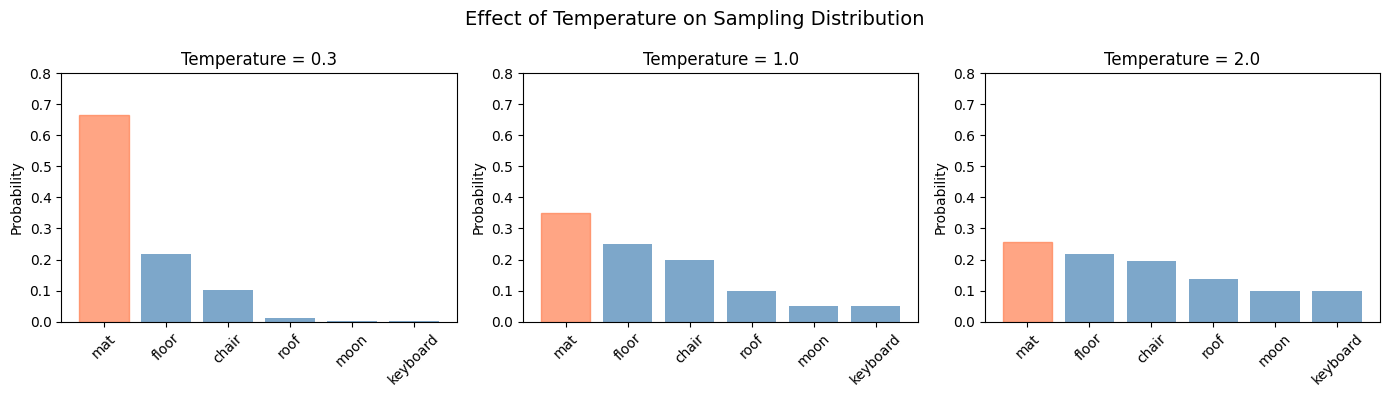

In [ ]:
# Visualize how temperature affects probability distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
temps = [0.3, 1.0, 2.0]

for ax, temp in zip(axes, temps):
    scaled = np.array(probs) ** (1/temp)
    scaled = scaled / scaled.sum()

    bars = ax.bar(words, scaled, color='steelblue', alpha=0.7)
    ax.set_title(f'Temperature = {temp}', fontsize=12)
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 0.8)
    ax.tick_params(axis='x', rotation=45)

    # Highlight the max
    max_idx = np.argmax(scaled)
    bars[max_idx].set_color('coral')

plt.suptitle('Effect of Temperature on Sampling Distribution', fontsize=14)
plt.tight_layout()
plt.show()

---

## 3. Demo: Generating Synthetic Data

Before generating complex content like images or text, let's understand the core principle: **learning a distribution and sampling from it**.

### Hands-On Demo: Learning a Distribution and Generating New Samples

**What to Expect:**
This demo simulates how generative models work by:
1. Creating "real" customer data with two clusters (budget and premium customers)
2. Using a Gaussian Mixture Model (GMM) to **learn** the underlying distribution
3. **Generating new synthetic data** that follows the same patterns

**Learning Objectives:**
- Understand the core principle of generative AI: learning distributions and sampling from them
- See how a model can capture the "essence" of data without memorizing specific examples
- Observe that generated data maintains the same statistical properties as real data

**What to Watch For:**
- The left plot shows the **original data** with two distinct customer clusters
- The right plot shows **generated data** that looks similar but contains entirely new points
- Notice how the model learned to generate points in the same regions/patterns as the real data

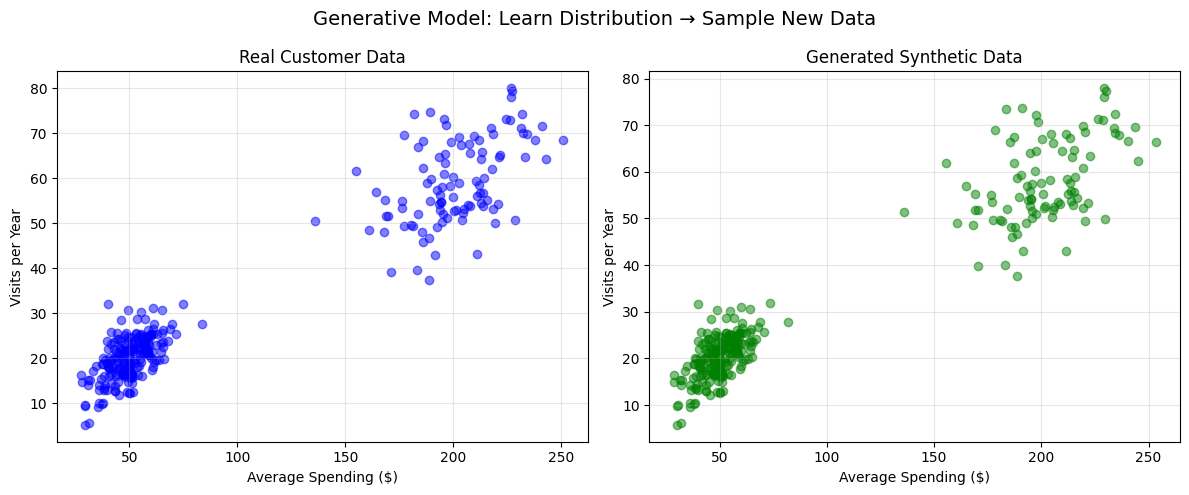

💡 Key insight: The model learned the DISTRIBUTION of real data,
   then generated NEW points that follow the same patterns!


In [ ]:
# Demo: Generate synthetic 2D data that matches a distribution

# Step 1: Create some "real" data (let's say customer spending patterns)
np.random.seed(42)

# Two clusters: budget customers and premium customers
budget_customers = np.random.multivariate_normal(
    mean=[50, 20],  # avg spending $50, 20 visits/year
    cov=[[100, 30], [30, 25]],
    size=200
)

premium_customers = np.random.multivariate_normal(
    mean=[200, 60],  # avg spending $200, 60 visits/year
    cov=[[400, 100], [100, 100]],
    size=100
)

real_data = np.vstack([budget_customers, premium_customers])

# Step 2: Simple generative approach - fit Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# "Learn" the distribution
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(real_data)

# Step 3: Generate NEW synthetic data by sampling from learned distribution
synthetic_data, _ = gmm.sample(300)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(real_data[:, 0], real_data[:, 1], alpha=0.5, c='blue')
axes[0].set_xlabel('Average Spending ($)')
axes[0].set_ylabel('Visits per Year')
axes[0].set_title('Real Customer Data', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, c='green')
axes[1].set_xlabel('Average Spending ($)')
axes[1].set_ylabel('Visits per Year')
axes[1].set_title('Generated Synthetic Data', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Generative Model: Learn Distribution → Sample New Data', fontsize=14)
plt.tight_layout()
plt.show()

print("💡 Key insight: The model learned the DISTRIBUTION of real data,")
print("   then generated NEW points that follow the same patterns!")

---

## 4. Types of Generative Models

### Evolution of Generative Models

```
2013-2014: Autoencoders & VAEs              (Representation learning)
    │
    ▼
2014: GANs (Generative Adversarial Networks) (Realistic images)
    │
    ▼
2017: Transformers                           (Attention mechanism)
    │
    ▼
2018-2020: GPT, BERT                         (Language understanding)
    │
    ▼
2020-2022: Diffusion Models                  (DALL-E, Stable Diffusion)
    │
    ▼
2022-now: Large Multimodal Models            (GPT-4, Gemini, Claude)
```

### Key Architectures

| Model Type | Key Idea | Best For |
|------------|----------|----------|
| **Autoencoders** | Compress → Reconstruct | Learning representations |
| **VAEs** | Autoencoders + probabilistic latent space | Smooth generation |
| **GANs** | Generator vs Discriminator game | Realistic images |
| **Transformers** | Self-attention over sequences | Text, long-range dependencies |
| **Diffusion** | Denoise random noise step by step | High-quality images |

---

## 5. Latent Space: The Secret Sauce

### What is Latent Space?

A **latent space** is a compressed representation of data where similar items are close together.

```
High-Dimensional Data              Latent Space (Low-Dimensional)
    ┌─────────────┐                      ┌─────────────┐
    │ Image:      │                      │      •cat   │
    │ 28x28=784   │  ────Encode────►     │   •dog      │
    │ dimensions  │                      │      •tiger │
    └─────────────┘                      │  (2-10 dim) │
                                         └─────────────┘
```

### Why it Matters for Generation

1. **Compression:** Complex data is compressed to essential features
2. **Interpolation:** Moving in latent space creates smooth transitions
3. **Manipulation:** Arithmetic in latent space changes attributes
4. **Sampling:** Random points in latent space decode to new content

**Famous Example:** Word2Vec showed that:
```
vector("King") - vector("Man") + vector("Woman") ≈ vector("Queen")
```

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


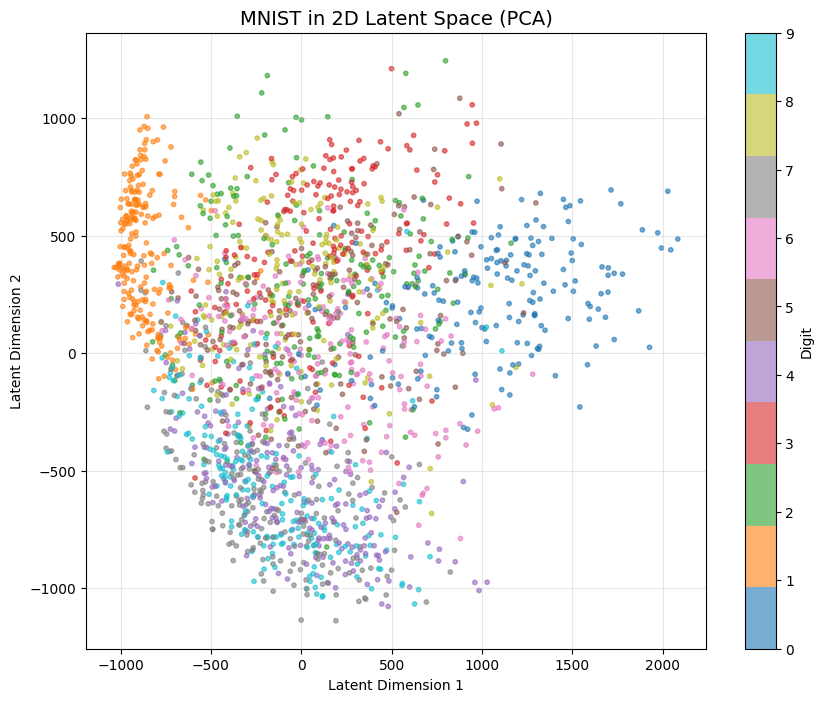

💡 Notice: Similar digits cluster together in latent space!
   The model learned that certain features matter for distinguishing digits.


In [ ]:
# Demo: Visualizing Latent Space with PCA
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

# Load MNIST for visualization
from tensorflow.keras.datasets import mnist
(X_train, y_train), (_, _) = mnist.load_data()

# Take a subset and flatten
X_subset = X_train[:2000].reshape(-1, 784)
y_subset = y_train[:2000]

# Compress 784 dimensions → 2 dimensions (latent space approximation)
pca = PCA(n_components=2)
X_latent = pca.fit_transform(X_subset)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_latent[:, 0], X_latent[:, 1],
                      c=y_subset, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Digit')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('MNIST in 2D Latent Space (PCA)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Notice: Similar digits cluster together in latent space!")
print("   The model learned that certain features matter for distinguishing digits.")

---

## 6. Autoencoder Architecture

An **autoencoder** is a neural network that learns to compress and reconstruct data.

```
Input ──► [Encoder] ──► Latent Code ──► [Decoder] ──► Reconstruction
  x            ↓            z              ↓              x'
             Compress                   Decompress
           (784→32)                     (32→784)
```

### Why Train to Reconstruct?

- Forces the network to learn **meaningful features**
- The latent code must capture the "essence" of the input
- Forms the basis for more powerful models like VAEs

### Loss Function

```
Reconstruction Loss = ||x - x'||² (Mean Squared Error)
```

The network learns to minimize the difference between input and output.

In [ ]:
# Build a Simple Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess MNIST
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Define the autoencoder
latent_dim = 32  # Compress from 784 → 32

# Encoder
encoder_inputs = layers.Input(shape=(784,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

encoder = keras.Model(encoder_inputs, latent, name='encoder')

# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(decoder_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(784, activation='sigmoid')(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')

# Full autoencoder
autoencoder = keras.Model(encoder_inputs, decoder(encoder(encoder_inputs)), name='autoencoder')

autoencoder.compile(optimizer='adam', loss='mse')

print("Autoencoder Architecture:")
print(f"  Input: 784 → Encoder → Latent: {latent_dim} → Decoder → Output: 784")
print(f"\nTotal parameters: {autoencoder.count_params():,}")

Autoencoder Architecture:
  Input: 784 → Encoder → Latent: 32 → Decoder → Output: 784

Total parameters: 476,720


In [ ]:
# Train the autoencoder
print("Training autoencoder...")
history = autoencoder.fit(
    X_train, X_train,  # Input = Target (reconstruction)
    epochs=10,
    batch_size=256,
    validation_data=(X_test, X_test),
    verbose=1
)
print("\n✅ Training complete!")

Training autoencoder...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0842 - val_loss: 0.0286
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0254 - val_loss: 0.0190
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.0156
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - val_loss: 0.0094

✅ Training complete!


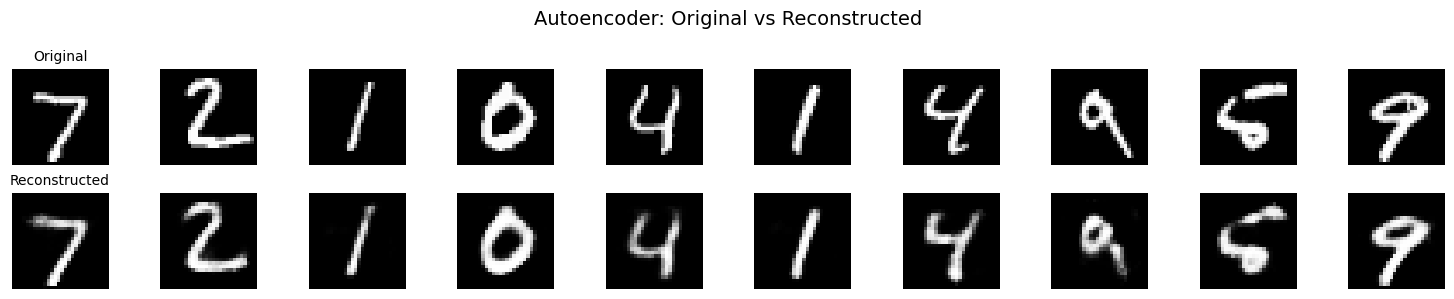

💡 The autoencoder compressed 784 pixels → 32 numbers → reconstructed 784 pixels!


In [ ]:
# Visualize reconstructions
reconstructions = autoencoder.predict(X_test[:10], verbose=0)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original
    axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)

    # Reconstruction
    axes[1, i].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10)

plt.suptitle('Autoencoder: Original vs Reconstructed', fontsize=14)
plt.tight_layout()
plt.show()

print("💡 The autoencoder compressed 784 pixels → 32 numbers → reconstructed 784 pixels!")

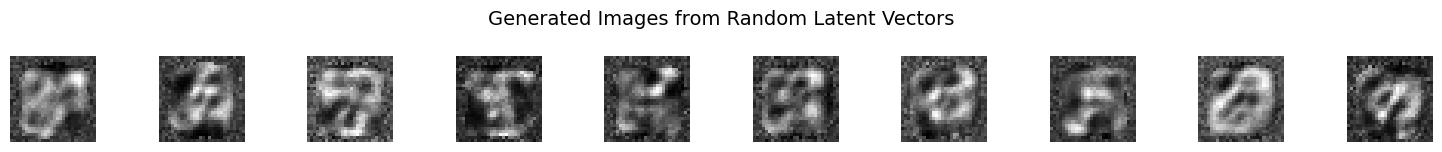

   These don't look like digits! Why?
   Basic autoencoders don't have a well-structured latent space.
   Solution: Variational Autoencoders (VAEs) - covered in the next notebook!


In [ ]:
# Generate NEW images by sampling random points in latent space
random_latent_vectors = np.random.randn(10, latent_dim)
generated_images = decoder.predict(random_latent_vectors, verbose=0)

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    axes[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.suptitle('Generated Images from Random Latent Vectors', fontsize=14)
plt.tight_layout()
plt.show()

print("   These don't look like digits! Why?")
print("   Basic autoencoders don't have a well-structured latent space.")
print("   Solution: Variational Autoencoders (VAEs) - covered in the next notebook!")

---

## 7. Connection to LLMs and Modern GenAI

The concepts we've learned are foundational to modern LLMs:

| Concept | In Autoencoders | In LLMs |
|---------|-----------------|----------|
| **Latent representation** | Compressed image code | Token embeddings |
| **Probabilistic sampling** | Sample from latent space | Sample next token |
| **Temperature** | Controls randomness | Controls creativity |
| **Reconstruction** | Reconstruct images | Predict next tokens |
| **Learned features** | Edge, shape detectors | Word relationships, context |

### The Path Forward

```
This Module:    Autoencoders, VAEs (learn representations)
     ↓
Module 4:       NLP basics (text as data)
     ↓
Module 5:       LLMs (Transformers, GPT, BERT)
     ↓
Module 6-9:     Apply to real tasks
```

---

## 📝 Student Activities

### Activity 1: Experiment with Temperature
Modify the word sampling code to:
1. Add more words to the vocabulary
2. Try extreme temperatures (0.1 and 5.0)
3. Observe how the distribution changes

### Activity 2: Modify the Autoencoder
1. Try different latent dimensions (2, 8, 64, 128)
2. How does reconstruction quality change?
3. What's the minimum latent dim for acceptable reconstructions?

### Activity 3: Explore Latent Space
1. Encode two different digits
2. Interpolate between their latent representations
3. Decode the intermediate points

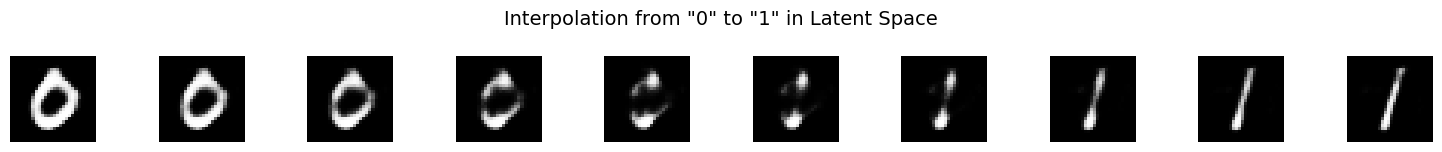

In [ ]:
# Activity 3 Starter: Latent Space Interpolation

# Find a 0 and a 1
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_flat = X_test.astype('float32').reshape(-1, 784) / 255.0

idx_0 = np.where(y_test == 0)[0][0]
idx_1 = np.where(y_test == 1)[0][0]

# Encode both
z_0 = encoder.predict(X_test_flat[idx_0:idx_0+1], verbose=0)
z_1 = encoder.predict(X_test_flat[idx_1:idx_1+1], verbose=0)

# Interpolate in latent space
steps = 10
interpolations = []
for alpha in np.linspace(0, 1, steps):
    z_interp = (1 - alpha) * z_0 + alpha * z_1
    decoded = decoder.predict(z_interp, verbose=0)
    interpolations.append(decoded.reshape(28, 28))

# Visualize
fig, axes = plt.subplots(1, steps, figsize=(15, 1.5))
for i, img in enumerate(interpolations):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.suptitle('Interpolation from "0" to "1" in Latent Space', fontsize=14)
plt.tight_layout()
plt.show()

---

## Key Takeaways

1. **Generative AI** creates new content by learning data distributions and sampling from them
2. **Temperature** controls the randomness/creativity of generation
3. **Latent space** is a compressed representation where similar things are near each other
4. **Autoencoders** learn to compress and reconstruct data (encode → latent → decode)
5. These foundations lead directly to **VAEs, GANs, and eventually Transformers/LLMs**

---

### Continue with:
- **02_autoencoders.ipynb** - Deep dive into autoencoder architectures
- **03_vae.ipynb** - Variational Autoencoders with proper latent space

### Next Module: NLP - Understanding Language as Data →